In [1028]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, precision_recall_curve, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

player_df = pd.read_json("data/1980-2018-per100-labeled.json")
player_df19 = pd.read_json("data/2019-per-100.json")
combined_df = pd.read_json("data/combined-player-team-stats.json")
combined_df19 = pd.read_json("data/2019-combined.json")

In [1029]:
combined_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA_x', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA_x', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x',
       'ORtg', 'DRtg', 'Year', 'MVP', 'player_id', 'GP', 'WINS', 'LOSSES',
       'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES',
       'CONF_COUNT', 'DIV_COUNT', 'NBA_FINALS_APPEARANCE', 'FGM', 'FGA_y',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA_y', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST_y', 'PF_y', 'STL_y', 'TOV_y', 'BLK_y', 'PTS_y',
       'PTS_RANK'],
      dtype='object')

In [1030]:
y_features = "MVP"
#x_features = ["Player","Year","Tm","MP","FG","FGA","3P","3PA","2P","2PA","FT","FTA","ORB","DRB","AST","STL","BLK","TOV","PF","PTS"]
x_features = ['Player', 'Year', 'Tm', 'MP', 'FG', 'FGA_x',
       '3P', '3PA', '2P', '2PA', 'FT', 'FTA_x', 'ORB',
       'DRB', 'TRB', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x',
       'ORtg', 'DRtg',
       'WIN_PCT', 'CONF_RANK',
        'REB','PTS_y']
#x_all = player_df[x_features]
x_all = combined_df[x_features]
#y_all = player_df[y_features]
y_all = combined_df[y_features]
# Drop the columns containing text data, leaving only numerical data
drop_txt = lambda x: x.drop(columns=["Player","Year", "Tm"])
x_all_num = dropper(x_all)

In [1031]:
x_old = x_all.loc[x_all.Year > 1980]
y_old = y_all.loc[x_all.Year > 1980]
x_19 = combined_df19[x_features]
x_19 = x_19[x_19['MP'] > 800]
x_train, x_test, y_train, y_test = train_test_split(x_old, y_old, test_size=0.3)

In [1032]:
x_train_num = drop_txt(x_train)
x_test_num = drop_txt(x_test) 
x_old_num = drop_txt(x_old) 
x_new_num = drop_txt(x_19)
x_train_num = x_old_num
y_train = y_old

In [1033]:
scale_pipe = lambda x: Pipeline([("scaler", StandardScaler()), x])
calibrate = lambda x: CalibratedClassifierCV(x, method='isotonic')

In [1034]:
xgb_calib = calibrate(XGBClassifier(learning_rate = 0.1, n_jobs=2, n_estimators=500))
xgb_uncalib = XGBClassifier(learning_rate = 0.1, n_jobs=2, n_estimators=500)
xgb_clf = scale_pipe(("xgb", xgb_calib))
xgb_clf_u = scale_pipe(("xgb", xgb_uncalib))
xgb_clf.fit(x_train_num, y_train)
xgb_clf_u.fit(x_train_num, y_train)
#precf_gb, recf_gb, thrf_gb = precision_recall_curve(y_test, xgb_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
#plt.plot(recf_gb, precf_gb)
xgb_feat = xgb_clf_u.named_steps['xgb'].feature_importances_

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

In [1035]:
xgb_pred_prob = xgb_clf.predict_proba(x_new_num).transpose()[1]
xgb_pred_indices = np.where(xgb_pred_prob > 0.1)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [1036]:
rf_calib = calibrate(RandomForestClassifier(n_jobs=2, n_estimators=500, max_features="auto"))
rf_uncalib = RandomForestClassifier(n_jobs=2,n_estimators=500, max_features="auto")
rf_clf = scale_pipe(("forest", rf_calib))
rf_clf_u = scale_pipe(("rf", rf_uncalib))
rf_clf.fit(x_train_num, y_train)
rf_clf_u.fit(x_old_num, y_old)
rf_pred_prob = rf_clf.predict_proba(x_new_num).transpose()[1]
#precf_rf,recf_rf,thrf_rf = precision_recall_curve(y_test, rf_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
#plt.plot(recf_rf, precf_rf)
feature_import = rf_clf_u.named_steps['rf'].feature_importances_

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

In [1046]:
interp = 0.5
stacked_prob = np.mean([xgb_pred_prob, rf_pred_prob], axis=0)
stacked_indices = np.where(stacked_prob > 0.03)
stacked_prob[stacked_indices]
x_19['Probability'] = stacked_prob
mvp_candiates = x_19.iloc[stacked_indices]
#x_19[x_19['MP'] > 900].sort_values(by='Probability',ascending=False)
mvp_candidates = x_19.loc[x_19.Probability > 0.1]
mvp_candidates.to_json("data/mvp-predict-2019-beta.json")

In [1044]:
mvp_summary = mvp_candiates.sort_values(by='Probability',ascending=False)[['Player','Probability']]
mvp_summary

,Player,Probability
64,Giannis Antetokounmpo,0.423648
281,James Harden,0.295455
78,Stephen Curry,0.181818
372,Kawhi Leonard,0.082633
156,Anthony Davis,0.061800
293,Joel Embiid,0.061800
80,Kevin Durant,0.045491


In [1040]:
x_19[x_19['MP'] > 900].sort_values(by='Probability',ascending=False)

,Player,Year,Tm,MP,FG,FGA_x,3P,3PA,2P,2PA,...,TOV_x,PF_x,PTS_x,ORtg,DRtg,WIN_PCT,CONF_RANK,REB,PTS_y,Probability
64,Giannis Antetokounmpo,2019,MIL,1277,13.9,23.9,0.6,3.3,13.3,20.6,...,5.7,4.7,37.1,118.0,100,0.725,1,1975,4701,0.423648
281,James Harden,2019,HOU,1408,13.3,30.4,6.6,17.0,6.7,13.4,...,7.6,4.6,45.9,118.0,110,0.575,6,1685,4425,0.295455
78,Stephen Curry,2019,GSW,1070,13.4,27.5,7.0,15.8,6.4,11.7,...,4.3,3.5,40.0,121.0,111,0.659,2,1889,4784,0.181818
372,Kawhi Leonard,2019,TOR,1177,13.2,26.3,2.4,6.6,10.8,19.7,...,2.8,2.1,37.8,121.0,105,0.721,2,1927,4866,0.082633
293,Joel Embiid,2019,PHI,1348,12.5,25.5,1.6,5.4,10.9,20.1,...,4.9,4.7,37.8,114.0,105,0.643,4,1997,4813,0.061800
156,Anthony Davis,2019,NOP,1368,13.2,25.7,1.2,3.7,12.0,21.9,...,2.6,3.2,36.8,125.0,105,0.476,12,1967,4922,0.061800
80,Kevin Durant,2019,GSW,1497,13.1,25.8,2.5,6.7,10.6,19.1,...,4.5,2.5,37.9,120.0,110,0.659,2,1889,4784,0.045491
334,Nikola Vucevic,2019,ORL,1230,13.5,25.5,1.9,4.9,11.6,20.6,...,3.2,3.2,32.4,115.0,104,0.415,10,1766,4221,0.024411
367,Lou Williams,2019,LAC,934,11.1,26.3,2.5,6.7,8.6,19.6,...,4.4,1.8,35.0,112.0,116,0.600,4,1834,4639,0.008772
401,LeBron James,2019,LAL,1178,13.4,25.9,2.7,7.5,10.7,18.4,...,4.6,2.1,36.7,116.0,106,0.548,8,1963,4712,0.008772


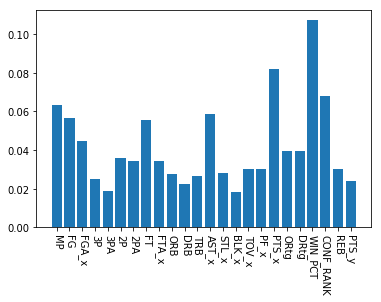

<BarContainer object of 24 artists>

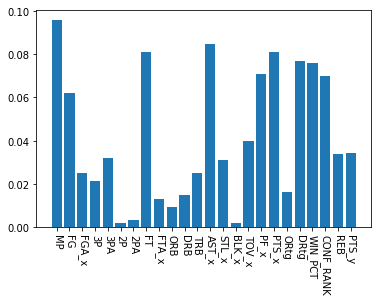

In [1042]:
plt.xticks(rotation=-90)
plt.bar(x_features[3:], feature_import)
plt.show()
plt.xticks(rotation=-90)
plt.bar(x_features[3:], xgb_feat)